# 🧬 Histopathologic Cancer Detection – CNN Experiments & Model Profiling

### 📘 Project Overview
This notebook implements a **Convolutional Neural Network (CNN) training pipeline** for the [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/) dataset.
The goal is to classify small 96×96 (or downsampled 64×64) tissue images as **cancerous vs. non-cancerous**, while systematically analyzing model efficiency, speed, and performance.

### Github Location
https://github.com/MSVWalker/cu-boulder-ms-ai/blob/main/Introduction-to-Machine-Learning/deep-learning/Week-03-CNN-Cancer-Detection-Kaggle-Mini-Project/CNN%20Cancer%20Detection%20Kaggle%20Mini-Project.ipynb

### ⚙️ Key Features
- **Custom CNN models from scratch** — no transfer learning.
- **Optimized preprocessing** with `.npy` caching for fast I/O on large image sets.
- **MPS/GPU-safe training** loops with detailed per-step timing (fetch, transfer, forward, backward, etc.).
- **Integrated profiling utilities** for throughput, per-batch timing, and device performance.
- **Automated hyperparameter sweeps**:
  - **Learning rate** (Adam optimizer)
  - **Weight decay** regularization
  - **Optimizer type** comparison (Adam, SGD, RMSprop, etc.)
  - **CNN depth and architecture** variations

### 🧪 Experimental Modules
| Experiment | Description | Objective |
|-------------|--------------|------------|
| **Base CNN Training** | 2-layer baseline model (`SmallCNN`) | Establish baseline loss, AUC, and speed. |
| **LR Sweep** | Test learning rates from `1e-4` to `1e-1` | Identify stable and optimal convergence regions. |
| **Weight Decay Sweep** | Apply L2 regularization | Measure generalization improvements. |
| **Optimizer Sweep** | Compare Adam, SGD, RMSprop, etc. | Assess optimizer speed/stability tradeoffs. |
| **Architecture Sweep** | Compare custom CNN variants (Wider, DeeperBN, TinyResNet, TinyMobile) | Evaluate capacity, generalization, and efficiency. |
| **Depth Sweep** | Systematically vary number of conv layers (1, 3, 5, 7) | Study effect of network depth on performance and runtime. |

### 📊 Metrics & Evaluation
Each experiment logs:
- **Train & validation loss / AUC** per epoch
- **Per-batch timing breakdown** (fetch → forward → backward → optimizer step)
- **Average throughput (images/sec)**
- **Parameter count** and **epoch time** for architecture comparisons

Visual outputs include:
- Multi-line plots of **loss** and **AUC vs. epoch**
- Bar charts of **model size**, **best validation AUC**, and **training time**

### 💡 Takeaways
These experiments collectively illustrate:
- How CNN depth, width, and normalization layers influence learning.
- The trade-off between **model complexity**, **training stability**, and **speed**.
- The benefit of **depthwise-separable convolutions (TinyMobile)** for fast, lightweight models.
- A reproducible, profiled framework for benchmarking CNN architectures in PyTorch.

---



## 📦 Imports & Environment

Well-organized imports for this notebook. Groups are kept minimal and purpose-driven.

### Core / Utils
- `pathlib.Path` for file paths
- `os`, `io`, `gc` for system I/O and cleanup
- `time`, `random`, `math` for timing and seeds
- `typing` for type hints (optional)

### Data & Imaging
- `pandas` for labels/CSV handling
- `numpy` for arrays and caching
- `PIL.Image` for image decoding

### Visualization
- `matplotlib.pyplot` for plots
- `tqdm` for progress bars

### PyTorch
- `torch`, `torch.nn`, `torch.optim` for models & training
- `torch.utils.data` for Dataset/DataLoader
- `torchvision.transforms` for augmentations

### Metrics
- `sklearn.metrics.roc_auc_score` for AUC

---

In [1]:
# ==== Core / Utils ====
from pathlib import Path
import os, io, gc, time, random, math
from typing import Dict, Any, Optional

# ==== Data & Imaging ====
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# ==== Visualization ====
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==== PyTorch ====
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary

# ==== Metrics ====
from sklearn.metrics import roc_auc_score

# ==== Imports ====
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


# reproducibility helper
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


##  Dataset Loading

In [2]:
# Try env vars, then walk up from CWD for a folder with the expected files
def find_root():
    cands = [os.getenv("PCAM_DIR"), os.getenv("DATA_DIR"), *map(str, Path.cwd().parents), str(Path.cwd())]
    for c in filter(None, cands):
        r = Path(c).expanduser().resolve()
        if (r/"train_labels.csv").is_file() and (r/"train").is_dir() and (r/"test").is_dir():
            return r
        s = r/"histopathologic-cancer-detection"
        if (s/"train_labels.csv").is_file() and (s/"train").is_dir() and (s/"test").is_dir():
            return s
    raise FileNotFoundError("Set PCAM_DIR or place the dataset under the working directory.")

DATA_DIR = find_root()
TRAIN_DIR, TEST_DIR, TRAIN_CSV = DATA_DIR/"train", DATA_DIR/"test", DATA_DIR/"train_labels.csv"

df = pd.read_csv(TRAIN_CSV)
print(df.shape, "unique ids:", df["id"].nunique(), "dups:", df["id"].duplicated().sum())

# quick file check
for _id in df["id"].drop_duplicates().sample(5, random_state=42):
    print(f"{_id}.tif -> {(TRAIN_DIR/f'{_id}.tif').exists()}")

(220025, 2) unique ids: 220025 dups: 0
d293308913e4a40cebb809d986aa9add65a76bfa.tif -> True
fcd55f03496afb4b11598d9c2231e86da318e723.tif -> True
5c983c8f14afeffdb098b9f3cbb68488a802b957.tif -> True
71bf03e8530348e57ec07d8ce2052f215390c997.tif -> True
1533406000e26663c5fadac3bcc3e38285a45bb3.tif -> True


## Class balance
Bar chart of label counts and proportions in the training set.

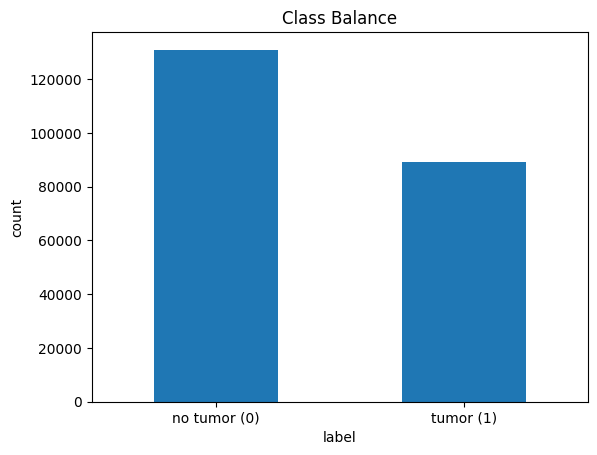

label
0    0.595
1    0.405
Name: proportion, dtype: float64


In [3]:
ax = df["label"].value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(["no tumor (0)", "tumor (1)"], rotation=0)
ax.set_title("Class Balance")
ax.set_xlabel("label"); ax.set_ylabel("count")
plt.show()

print(df["label"].value_counts(normalize=True).rename("proportion").round(4))

## Sample tiles
Quick grid of random training images with labels.

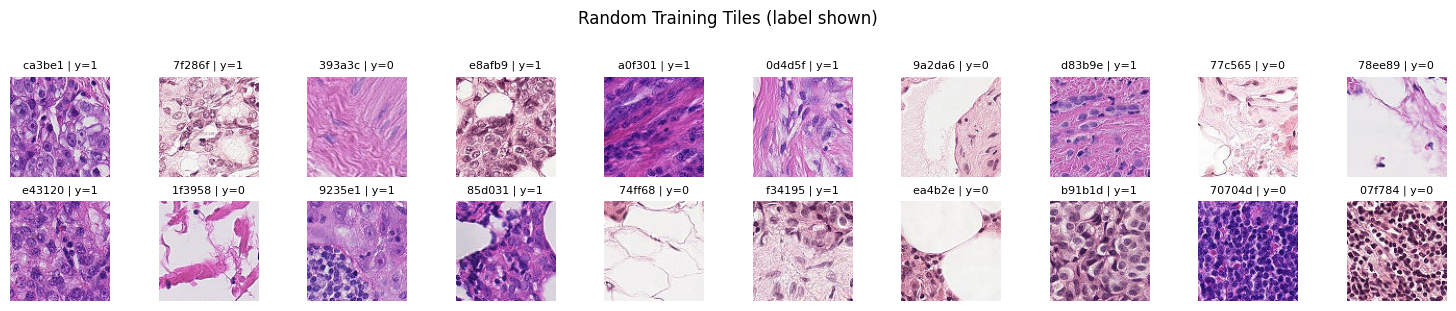

In [4]:
def show_samples(ids, labels=None, ncols=10, title="Random Training Tiles"):
    n = len(ids)
    ncols = min(ncols, n)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(ncols*1.5, nrows*1.5))
    for i, _id in enumerate(ids, 1):
        img = Image.open(TRAIN_DIR / f"{_id}.tif").convert("RGB")
        plt.subplot(nrows, ncols, i)
        plt.imshow(img)
        plt.axis("off")
        ttl = str(_id)[:6]
        if labels is not None:
            ttl += f" | y={int(labels[i-1])}"
        plt.title(ttl, fontsize=8)
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

rand_df = df.sample(20, random_state=123)
show_samples(rand_df["id"].tolist(), rand_df["label"].tolist(), ncols=10, title="Random Training Tiles (label shown)")

## Image dimensions check
Sample a subset of tiles and report the most common (width, height) sizes.

In [5]:
def sample_sizes(df, k=1000, seed=42):
    ids = df["id"].sample(min(k, len(df)), random_state=seed).tolist()
    sizes = []
    for _id in ids:
        with Image.open(TRAIN_DIR / f"{_id}.tif") as im:
            sizes.append(im.size)  # (width, height)
    return sizes

sizes = sample_sizes(df, k=500)
unique_sizes = pd.Series(sizes).value_counts()
print("Unique sizes in sample:\n", unique_sizes.head(10))

Unique sizes in sample:
 (96, 96)    500
Name: count, dtype: int64


## Intensity distribution
Histogram of mean pixel intensity across a sampled subset of training tiles.

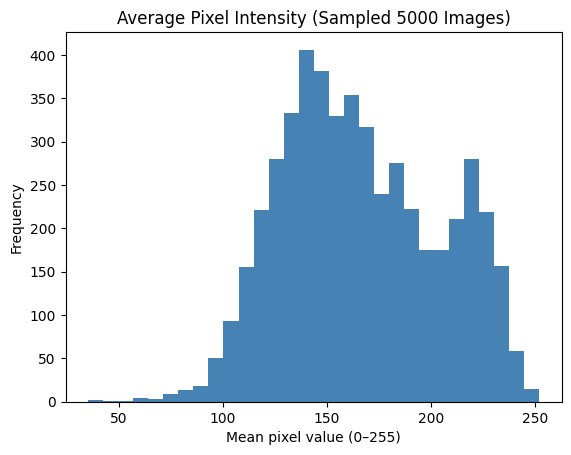

In [6]:
# sample 500 images to estimate pixel value ranges
vals = []
for _id in df["id"].sample(5000, random_state=123):
    arr = np.array(Image.open(TRAIN_DIR / f"{_id}.tif"))
    vals.append(arr.mean())

plt.hist(vals, bins=30, color="steelblue")
plt.title("Average Pixel Intensity (Sampled 5000 Images)")
plt.xlabel("Mean pixel value (0–255)")
plt.ylabel("Frequency")
plt.show()

## Channel stats
Compute per-channel mean/std on a sample (for normalization).

In [7]:

def channel_stats(sample_ids, k=2000):
    sample = df.sample(min(k, len(df)), random_state=7)["id"].tolist()
    s = np.zeros(3, dtype=np.float64)
    s2 = np.zeros(3, dtype=np.float64)
    npx = 0
    for _id in sample:
        x = np.asarray(Image.open(TRAIN_DIR / f"{_id}.tif").convert("RGB"), dtype=np.float32) / 255.0
        h, w, _ = x.shape
        npx += h*w
        s  += x.sum(axis=(0,1))
        s2 += (x**2).sum(axis=(0,1))
    mean = s / npx
    var  = s2 / npx - mean**2
    std  = np.sqrt(np.maximum(var, 0))
    return mean, std

mean, std = channel_stats(df["id"], k=2000)
print("Channel mean:", mean.round(4), " | std:", std.round(4))

Channel mean: [0.6945 0.536  0.6881]  | std: [0.2404 0.2813 0.2184]


## Class-wise mean tiles
Compute and display the average image for each class (0 vs 1) and a visual difference map.

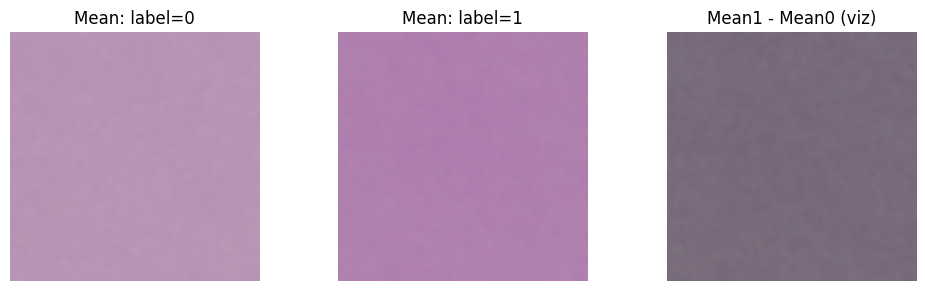

In [8]:
def mean_image(ids, k=2000):
    ids = ids.sample(min(k, len(ids)), random_state=1)
    acc = None
    for _id in ids:
        x = np.asarray(Image.open(TRAIN_DIR / f"{_id}.tif").convert("RGB"), dtype=np.float32)
        acc = x if acc is None else acc + x
    return (acc / len(ids)) / 255.0

mean0 = mean_image(df[df.label==0]["id"])
mean1 = mean_image(df[df.label==1]["id"])

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(mean0); plt.title("Mean: label=0"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mean1); plt.title("Mean: label=1"); plt.axis("off")
diff = np.clip((mean1 - mean0 + 0.5), 0, 1)  # visualize difference
plt.subplot(1,3,3); plt.imshow(diff); plt.title("Mean1 - Mean0 (viz)"); plt.axis("off")
plt.tight_layout(); plt.show()

## t-SNE (raw pixels)
Flatten a random subset of tiles to vectors and project to 2D with t-SNE to visualize class separability.

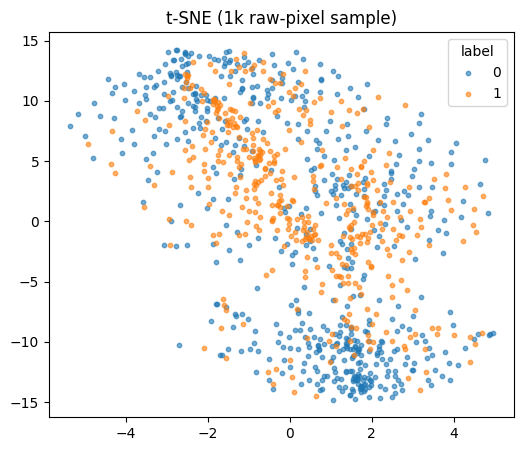

In [9]:
def to_matrix(ids, k=1000):
    ids = list(ids.sample(min(k, len(ids)), random_state=10))
    X, y = [], []
    for _id in ids:
        arr = np.asarray(Image.open(TRAIN_DIR / f"{_id}.tif").convert("RGB"), dtype=np.float32)
        X.append(arr.reshape(-1))           # flatten
        y.append(int(df.loc[df.id==_id, "label"].iloc[0]))
    return np.stack(X), np.array(y)

X, y = to_matrix(df["id"], k=1000)
ts = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=30, random_state=0)
Z = ts.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(Z[y==0,0], Z[y==0,1], s=10, alpha=0.6, label="0")
plt.scatter(Z[y==1,0], Z[y==1,1], s=10, alpha=0.6, label="1")
plt.legend(title="label"); plt.title("t-SNE (1k raw-pixel sample)")
plt.show()

## One-Time Image Caching

This section builds a local `.npy` cache of the histopathologic images for faster training.
Each `.tif` image is resized (e.g., 64×64) and saved as a compact NumPy array to avoid reloading
and resizing during each training epoch, significantly improving data-loading speed.

In [10]:
IMG_SIZE  = 64
CACHE_DIR = Path(f"cache_{IMG_SIZE}")
(CACHE_DIR/"train").mkdir(parents=True, exist_ok=True)
(CACHE_DIR/"test").mkdir(parents=True, exist_ok=True)

def cache_one(src: Path, dst: Path, s: int):
    if dst.exists(): return
    np.save(dst, np.asarray(Image.open(src).convert("RGB").resize((s, s)), dtype=np.uint8))

missing = 0
for _id in tqdm(df["id"], desc="cache train"):
    src = TRAIN_DIR/f"{_id}.tif"
    if not src.exists(): missing += 1; continue
    cache_one(src, CACHE_DIR/"train"/f"{_id}.npy", IMG_SIZE)

print("cache root:", CACHE_DIR.resolve(), "| missing:", missing)

cache train: 100%|██████████| 220025/220025 [01:05<00:00, 3343.84it/s]

cache root: /Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/Week 3/cache_64 | missing: 0


## Cached Dataset Loader

Defines a lightweight `Dataset` class that reads preprocessed `.npy` image tiles from disk.
It wraps them as PIL images for on-the-fly transforms and supports both labeled (train/val)
and unlabeled (test) splits. This avoids repeated `.tif` decoding and speeds up training.

In [11]:
train_tfms = transforms.Compose([transforms.ToTensor()])
valid_tfms = transforms.Compose([transforms.ToTensor()])

class PCamCached(Dataset):
    def __init__(self, df, cache_root, split="train", transform=None):
        self.df = df.reset_index(drop=True)
        self.root = Path(cache_root) / split
        self.transform = transform
        self.has_labels = "label" in self.df.columns

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        arr = np.load(self.root / f"{r['id']}.npy")  # HxWx3 uint8
        img = Image.fromarray(arr)                   # cheap → stays PIL for transforms
        if self.transform: img = self.transform(img)
        return (img, np.float32(r["label"])) if self.has_labels else (img, r["id"])

## Train/Validation Split and DataLoaders

Splits the dataset into training and validation sets (90/10 stratified),
builds `PCamCached` datasets, and creates `DataLoader` objects optimized
for macOS and MPS (Metal) backends. This setup ensures efficient batch loading
and compatibility for Apple Silicon devices.

In [12]:
# ==== Train/Val split → Datasets → DataLoaders (MPS-safe) ====
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)

ds_train = PCamCached(train_df, CACHE_DIR, split="train", transform=train_tfms)
ds_val   = PCamCached(val_df,   CACHE_DIR, split="train", transform=valid_tfms)

is_mps = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
BATCH_SIZE = 128
num_workers = 0 if is_mps else 4
pin_memory = not is_mps

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=num_workers, pin_memory=pin_memory)
dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=num_workers, pin_memory=pin_memory)

print(f"Train/Val sizes: {len(ds_train)} / {len(ds_val)} | Backend: {'MPS' if is_mps else 'CPU/GPU'}")

Train/Val sizes: 198022 / 22003 | Backend: MPS


## Reproducibility, Device, and Baseline Model

Sets a fixed seed, selects an available accelerator (CUDA/MPS/CPU), and defines a small CNN baseline (two conv–pool blocks → global avg pool → linear logit) with BCE-with-logits loss and Adam optimizer.

In [13]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # S/2
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # S/4
            nn.AdaptiveAvgPool2d(1)                                      # → [B,64,1,1]
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64, 1))

    def forward(self, x):
        return self.head(self.features(x)).squeeze(1)

model = SmallCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: mps


In [14]:
summary(model, input_size=(1, 3, 96, 96),  # (batch, channels, H, W)
        col_names=("input_size", "output_size", "num_params", "kernel_size"),
        depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SmallCNN                                 [1, 3, 96, 96]            [1]                       --                        --
├─Sequential: 1-1                        [1, 3, 96, 96]            [1, 64, 1, 1]             --                        --
│    └─Conv2d: 2-1                       [1, 3, 96, 96]            [1, 32, 96, 96]           896                       [3, 3]
│    └─ReLU: 2-2                         [1, 32, 96, 96]           [1, 32, 96, 96]           --                        --
│    └─MaxPool2d: 2-3                    [1, 32, 96, 96]           [1, 32, 48, 48]           --                        2
│    └─Conv2d: 2-4                       [1, 32, 48, 48]           [1, 64, 48, 48]           18,496                    [3, 3]
│    └─ReLU: 2-5                         [1, 64, 48, 48]           [1, 64, 48, 48]           --                        --
│    └─

## Training and Profiling Loop

This section defines a detailed training loop that profiles each phase of the batch cycle—data loading, transfer to device, forward pass, loss computation, backward pass, optimizer step, and metric collection.
It prints real-time performance statistics (in ms/batch) and computes epoch-level summaries, including AUC and average loss.

Key points:
- **`run_epoch_profiled()`**: Handles one epoch of training or validation with fine-grained timing.
- **Metrics**: Tracks both loss and ROC-AUC.
- **Safety checks**: Ensures model and data are on the same device (MPS, CUDA, or CPU).
- **History tracking**: Records per-epoch metrics for later visualization.
- **Visualization**: Produces line plots for loss and AUC across epochs and a summary DataFrame of results.

This setup allows precise performance comparison across model variants, batch sizes, or hardware backends.


=== Training (profiled, capped batches) ===

---- Epoch 1/15 ----
[train]  100/200 |  12800 imgs |   349.8 imgs/s | elapsed   36.6s | loss(last/avg) 0.4767/0.6176
   fetch  82.61 | h2d   0.01 | fwd 113.26 | loss   0.18 | bwd 169.33 | step   0.51 | metrics   0.03  (ms/batch)
[train]  200/200 |  25600 imgs |   397.3 imgs/s | elapsed   64.4s | loss(last/avg) 0.4499/0.5669
   fetch  76.40 | h2d   0.01 | fwd  96.05 | loss   0.13 | bwd 149.07 | step   0.47 | metrics   0.03  (ms/batch)
[train] DONE | avg_loss 0.5669 | AUC 0.7800 | epoch_time 64.4s
PER-BATCH AVERAGES (ms): fetch 76.40 | h2d 0.01 | fwd 96.05 | loss 0.13 | bwd 149.07 | step 0.47 | metrics 0.03
[valid]  100/172 |  12800 imgs |   871.0 imgs/s | elapsed   14.7s | loss(last/avg) 0.5198/0.4846
   fetch  66.49 | h2d   0.01 | fwd  78.30 | loss   2.10 | bwd   0.00 | step   0.00 | metrics   0.04  (ms/batch)
[valid]  172/172 |  22003 imgs |   873.4 imgs/s | elapsed   25.2s | loss(last/avg) 0.5514/0.4886
   fetch  67.04 | h2d   0.01 | fwd

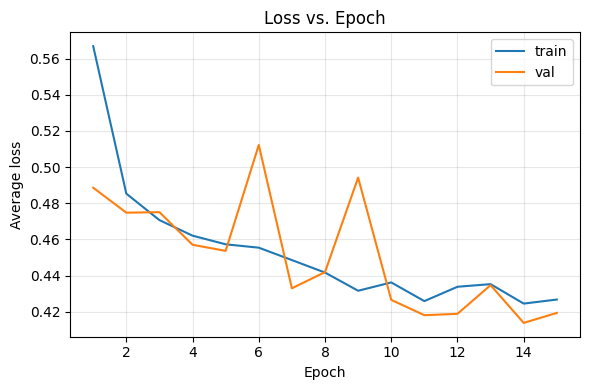

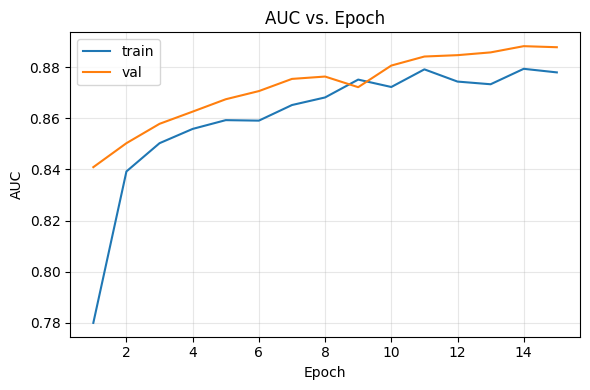

,epoch,train_loss,val_loss,train_auc,val_auc,train_time_s,val_time_s
0,1,0.5669,0.4886,0.7800,0.8409,64.4,25.2
1,2,0.4853,0.4748,0.8392,0.8503,55.5,25.5
2,3,0.4707,0.4751,0.8503,0.8578,55.9,27.0
3,4,0.4621,0.4570,0.8558,0.8626,81.8,66.6
4,5,0.4573,0.4537,0.8593,0.8674,154.8,35.5
5,6,0.4555,0.5122,0.8591,0.8706,77.4,34.6
6,7,0.4486,0.4330,0.8652,0.8754,77.2,35.7
7,8,0.4417,0.4419,0.8682,0.8763,81.8,35.3
8,9,0.4316,0.4942,0.8751,0.8722,78.1,35.1
9,10,0.4362,0.4266,0.8722,0.8806,79.4,31.1


In [15]:
# ================== Verbose epoch runner + per-step profiler (float32, MPS-safe) ==================


def run_epoch_profiled(
    model,
    loader,
    train=True,
    log_every=50,
    name="train",
    max_batches=None,           # <<<<< cap how many batches to process this epoch
):
    """
    Timed breakdown per batch:
      ① fetch (DataLoader -> CPU)
      ② h2d   (host->device)
      ③ fwd   (forward)
      ④ loss  (loss compute)
      ⑤ bwd   (backward)
      ⑥ step  (optimizer step)
      ⑦ metrics (collect preds/labels to CPU)
    Prints rolling averages every `log_every` batches and a summary at the end.
    Returns: avg_loss, auc, epoch_time_seconds, timings_dict(ms_per_batch)
    """
    device = next(model.parameters()).device
    model.train() if train else model.eval()

    total_loss, n_seen, batches = 0.0, 0, 0
    y_true, y_pred = [], []

    # timing accumulators
    t_fetch = t_h2d = t_fwd = t_loss = t_bwd = t_step = t_metrics = 0.0

    epoch_start = time.perf_counter()
    it = iter(loader)
    steps = len(loader) if max_batches is None else min(max_batches, len(loader))
    last_loss = float("nan")

    for i in range(steps):
        # ① FETCH
        t0 = time.perf_counter()
        xb, yb = next(it)
        t_fetch += time.perf_counter() - t0

        # ② HOST→DEVICE + label fix
        t0 = time.perf_counter()
        xb = xb.to(device, non_blocking=True)
        yb = torch.as_tensor(yb, dtype=torch.float32, device=device).view(-1)
        t_h2d += time.perf_counter() - t0

        # ③ FORWARD
        t0 = time.perf_counter()
        logits = model(xb)
        t_fwd += time.perf_counter() - t0

        # ④ LOSS
        t0 = time.perf_counter()
        loss = criterion(logits, yb)
        t_loss += time.perf_counter() - t0
        last_loss = loss.item()

        # ⑤ BACKWARD
        if train:
            t0 = time.perf_counter()
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            t_bwd += time.perf_counter() - t0

            # ⑥ OPT STEP
            t0 = time.perf_counter()
            optimizer.step()
            t_step += time.perf_counter() - t0

        # accumulate
        bs = xb.size(0)
        total_loss += last_loss * bs
        n_seen += bs

        # ⑦ METRICS BUFFER
        t0 = time.perf_counter()
        with torch.no_grad():
            y_true.append(yb.detach().cpu().numpy())
            y_pred.append(torch.sigmoid(logits).detach().cpu().numpy())
        t_metrics += time.perf_counter() - t0

        batches += 1

        if ((i + 1) % log_every == 0) or (i + 1 == steps):
            elapsed = time.perf_counter() - epoch_start
            ips = n_seen / max(elapsed, 1e-6)
            avg_ms = lambda s: (s / batches) * 1000.0
            running_avg_loss = total_loss / max(n_seen, 1)
            print(
                f"[{name}] {i+1:>4}/{steps} | {n_seen:>6} imgs | {ips:7.1f} imgs/s | "
                f"elapsed {elapsed:6.1f}s | loss(last/avg) {last_loss:.4f}/{running_avg_loss:.4f}\n"
                f"   fetch {avg_ms(t_fetch):6.2f} | h2d {avg_ms(t_h2d):6.2f} | fwd {avg_ms(t_fwd):6.2f} | "
                f"loss {avg_ms(t_loss):6.2f} | bwd {avg_ms(t_bwd):6.2f} | step {avg_ms(t_step):6.2f} | "
                f"metrics {avg_ms(t_metrics):6.2f}  (ms/batch)"
            )

    # epoch end
    y_true = np.concatenate(y_true) if len(y_true) else np.array([])
    y_pred = np.concatenate(y_pred) if len(y_pred) else np.array([])
    try:
        auc = roc_auc_score(y_true, y_pred) if len(y_true) else float("nan")
    except ValueError:
        auc = float("nan")
    avg_loss = total_loss / max(n_seen, 1)
    epoch_time = time.perf_counter() - epoch_start

    avg_ms = lambda s: (s / max(batches, 1)) * 1000.0
    timings = {
        "fetch_ms":   avg_ms(t_fetch),
        "h2d_ms":     avg_ms(t_h2d),
        "fwd_ms":     avg_ms(t_fwd),
        "loss_ms":    avg_ms(t_loss),
        "bwd_ms":     avg_ms(t_bwd),
        "step_ms":    avg_ms(t_step),
        "metrics_ms": avg_ms(t_metrics),
    }

    print(
        f"[{name}] DONE | avg_loss {avg_loss:.4f} | AUC {auc:.4f} | epoch_time {epoch_time:.1f}s\n"
        f"PER-BATCH AVERAGES (ms): fetch {timings['fetch_ms']:.2f} | h2d {timings['h2d_ms']:.2f} | "
        f"fwd {timings['fwd_ms']:.2f} | loss {timings['loss_ms']:.2f} | bwd {timings['bwd_ms']:.2f} | "
        f"step {timings['step_ms']:.2f} | metrics {timings['metrics_ms']:.2f}"
    )
    return avg_loss, auc, epoch_time, timings

# ================== Training loop using the profiled runner (capped batches) ==================
EPOCHS = 15
MAX_BATCHES_TRAIN = 200    # <<<<< only take this many train batches per epoch
MAX_BATCHES_VAL   = 200   # validate on full val set (or set a small int to cap)

best_auc, best_state = -1.0, None
history = {
    "train_loss": [], "train_auc": [], "train_time": [], "train_timing": [],
    "val_loss":   [], "val_auc":   [], "val_time":   [], "val_timing":   [],
}

# Safety check: model/device alignment
assert next(model.parameters()).device.type == ( "mps" if hasattr(torch.backends,"mps") and torch.backends.mps.is_available() and next(model.parameters()).device.type=="mps" else next(model.parameters()).device.type)

print("\n=== Training (profiled, capped batches) ===")
for epoch in range(1, EPOCHS + 1):
    print(f"\n---- Epoch {epoch}/{EPOCHS} ----")
    tr_loss, tr_auc, tr_time, tr_tim = run_epoch_profiled(
        model, dl_train, train=True,  log_every=100, name="train", max_batches=MAX_BATCHES_TRAIN
    )
    va_loss, va_auc, va_time, va_tim = run_epoch_profiled(
        model, dl_val,   train=False, log_every=100, name="valid", max_batches=MAX_BATCHES_VAL
    )

    history["train_loss"].append(tr_loss)
    history["train_auc"].append(tr_auc)
    history["train_time"].append(tr_time)
    history["train_timing"].append(tr_tim)

    history["val_loss"].append(va_loss)
    history["val_auc"].append(va_auc)
    history["val_time"].append(va_time)
    history["val_timing"].append(va_tim)

    print(f"Epoch {epoch:02d} summary | "
          f"train: loss {tr_loss:.4f}, AUC {tr_auc:.4f}, time {tr_time:.1f}s | "
          f"valid: loss {va_loss:.4f}, AUC {va_auc:.4f}, time {va_time:.1f}s")

    if va_auc > best_auc:
        best_auc = va_auc
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        print(f"** New best AUC {best_auc:.4f} — weights updated.")

if best_state is not None:
    model.load_state_dict(best_state)

print(f"\nBest val AUC: {best_auc:.4f}")


epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_loss"], label="train")
plt.plot(epochs, history["val_loss"],   label="val")
plt.xlabel("Epoch"); plt.ylabel("Average loss"); plt.title("Loss vs. Epoch")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_auc"], label="train")
plt.plot(epochs, history["val_auc"],   label="val")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("AUC vs. Epoch")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("auc_vs_epoch.png", dpi=150)
plt.show()


summary_df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "train_auc": history["train_auc"],
    "val_auc": history["val_auc"],
    "train_time_s": history["train_time"],
    "val_time_s": history["val_time"],
})
display(summary_df.style.format({"train_time_s":"{:.1f}","val_time_s":"{:.1f}","train_auc":"{:.4f}","val_auc":"{:.4f}","train_loss":"{:.4f}","val_loss":"{:.4f}"}))

## Patched Training Runner

This version of the profiled epoch runner accepts the optimizer as an explicit argument instead of relying on a global variable.
It improves modularity and makes the function reusable across experiments with different optimizers or loss functions.

Key details:
- **`optimizer`** must be passed when `train=True`; otherwise, an error is raised.
- Tracks time for each stage of the training loop (fetch → host-to-device → forward → loss → backward → step → metrics).
- Returns epoch-level averages for loss, AUC, total time, and per-batch timings.
- Can be used for both training and validation by toggling `train` and `optimizer`.

This modular version keeps the training logic clean and flexible for sweeps or comparative runs.

In [16]:
# ---- patched runner: pass optimizer in explicitly ----
def run_epoch_profiled(
    model,
    loader,
    train=True,
    log_every=50,
    name="train",
    max_batches=None,
    optimizer=None,              # <— NEW
    criterion=criterion,         # use your global unless you pass another
):
    device = next(model.parameters()).device
    if train and optimizer is None:
        raise ValueError("When train=True, you must pass an optimizer.")

    model.train() if train else model.eval()

    import time, numpy as np
    from sklearn.metrics import roc_auc_score

    total_loss, n_seen, batches = 0.0, 0, 0
    y_true, y_pred = [], []

    t_fetch = t_h2d = t_fwd = t_loss = t_bwd = t_step = t_metrics = 0.0
    epoch_start = time.perf_counter()
    it = iter(loader)
    steps = len(loader) if max_batches is None else min(max_batches, len(loader))
    last_loss = float("nan")

    for i in range(steps):
        # ① fetch
        t0 = time.perf_counter()
        xb, yb = next(it)
        t_fetch += time.perf_counter() - t0

        # ② h2d
        t0 = time.perf_counter()
        xb = xb.to(device, non_blocking=True)
        yb = torch.as_tensor(yb, dtype=torch.float32, device=device).view(-1)
        t_h2d += time.perf_counter() - t0

        # ③ fwd
        t0 = time.perf_counter()
        logits = model(xb)
        t_fwd += time.perf_counter() - t0

        # ④ loss
        t0 = time.perf_counter()
        loss = criterion(logits, yb)
        t_loss += time.perf_counter() - t0
        last_loss = loss.item()

        # ⑤/⑥ backward + step (only when training)
        if train:
            t0 = time.perf_counter()
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            t_bwd += time.perf_counter() - t0

            t0 = time.perf_counter()
            optimizer.step()
            t_step += time.perf_counter() - t0

        # accumulate
        bs = xb.size(0)
        total_loss += last_loss * bs
        n_seen += bs

        # ⑦ metrics buffer
        t0 = time.perf_counter()
        with torch.no_grad():
            y_true.append(yb.detach().cpu().numpy())
            y_pred.append(torch.sigmoid(logits).detach().cpu().numpy())
        t_metrics += time.perf_counter() - t0

        batches += 1
        if ((i + 1) % log_every == 0) or (i + 1 == steps):
            elapsed = time.perf_counter() - epoch_start
            ips = n_seen / max(elapsed, 1e-6)
            avg_ms = lambda s: (s / batches) * 1000.0
            running_avg_loss = total_loss / max(n_seen, 1)
            print(
                f"[{name}] {i+1:>4}/{steps} | {n_seen:>6} imgs | {ips:7.1f} imgs/s | "
                f"elapsed {elapsed:6.1f}s | loss(last/avg) {last_loss:.4f}/{running_avg_loss:.4f}\n"
                f"   fetch {avg_ms(t_fetch):6.2f} | h2d {avg_ms(t_h2d):6.2f} | fwd {avg_ms(t_fwd):6.2f} | "
                f"loss {avg_ms(t_loss):6.2f} | bwd {avg_ms(t_bwd):6.2f} | step {avg_ms(t_step):6.2f} | "
                f"metrics {avg_ms(t_metrics):6.2f}  (ms/batch)"
            )

    # epoch end
    y_true = np.concatenate(y_true) if len(y_true) else np.array([])
    y_pred = np.concatenate(y_pred) if len(y_pred) else np.array([])
    try:
        auc = roc_auc_score(y_true, y_pred) if len(y_true) else float("nan")
    except ValueError:
        auc = float("nan")
    avg_loss = total_loss / max(n_seen, 1)
    epoch_time = time.perf_counter() - epoch_start

    avg_ms = lambda s: (s / max(batches, 1)) * 1000.0
    timings = {
        "fetch_ms":   avg_ms(t_fetch),
        "h2d_ms":     avg_ms(t_h2d),
        "fwd_ms":     avg_ms(t_fwd),
        "loss_ms":    avg_ms(t_loss),
        "bwd_ms":     avg_ms(t_bwd),
        "step_ms":    avg_ms(t_step),
        "metrics_ms": avg_ms(t_metrics),
    }

    print(
        f"[{name}] DONE | avg_loss {avg_loss:.4f} | AUC {auc:.4f} | epoch_time {epoch_time:.1f}s\n"
        f"PER-BATCH AVERAGES (ms): fetch {timings['fetch_ms']:.2f} | h2d {timings['h2d_ms']:.2f} | "
        f"fwd {timings['fwd_ms']:.2f} | loss {timings['loss_ms']:.2f} | bwd {timings['bwd_ms']:.2f} | "
        f"step {timings['step_ms']:.2f} | metrics {timings['metrics_ms']:.2f}"
    )
    return avg_loss, auc, epoch_time, timings

## Learning Rate Sweep

This section runs a lightweight learning rate (LR) sweep to identify a stable and performant training rate for the model.

### Overview
- **Purpose:** Compare model stability and convergence speed across different learning rates using a fixed architecture (`SmallCNN`) and consistent batch settings.
- **Function:** `run_one_lr()` trains and validates the model for a few epochs, passing the optimizer explicitly into `run_epoch_profiled()` for each LR.
- **Metrics:** Tracks loss and AUC across epochs, saving the best model state per LR.
- **Visualization:**
  - *Validation Loss vs. Epoch* for each LR
  - *Validation AUC vs. Epoch* for each LR
- **Output:** A summary table ranking each learning rate by its best validation AUC.

This quick sweep helps choose a balanced LR that neither underfits (too low) nor diverges (too high).


===== LR SWEEP: lr=0.0001 =====

-- [lr=0.0001] Epoch 1/15 --
[train(lr=0.0001)]   50/200 |   6400 imgs |   746.7 imgs/s | elapsed    8.6s | loss(last/avg) 0.6769/0.6763
   fetch  80.40 | h2d   1.57 | fwd   3.84 | loss   6.76 | bwd   3.59 | step   1.94 | metrics  53.42  (ms/batch)
[train(lr=0.0001)]  100/200 |  12800 imgs |   790.3 imgs/s | elapsed   16.2s | loss(last/avg) 0.6425/0.6690
   fetch  78.69 | h2d   1.67 | fwd   2.34 | loss   3.49 | bwd   2.43 | step   1.47 | metrics  52.15  (ms/batch)
[train(lr=0.0001)]  150/200 |  19200 imgs |   814.7 imgs/s | elapsed   23.6s | loss(last/avg) 0.6347/0.6652
   fetch  77.59 | h2d   1.61 | fwd   1.80 | loss   2.39 | bwd   2.00 | step   1.27 | metrics  50.88  (ms/batch)
[train(lr=0.0001)]  200/200 |  25600 imgs |   799.2 imgs/s | elapsed   32.0s | loss(last/avg) 0.6466/0.6609
   fetch  80.17 | h2d   1.67 | fwd   1.59 | loss   1.85 | bwd   1.90 | step   1.24 | metrics  51.73  (ms/batch)
[train(lr=0.0001)] DONE | avg_loss 0.6609 | AUC 0.6650 | 

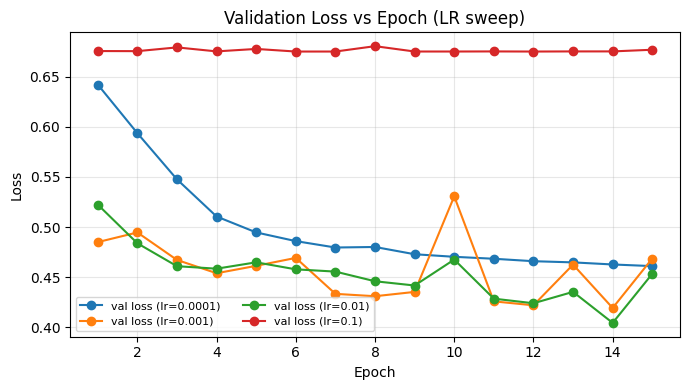

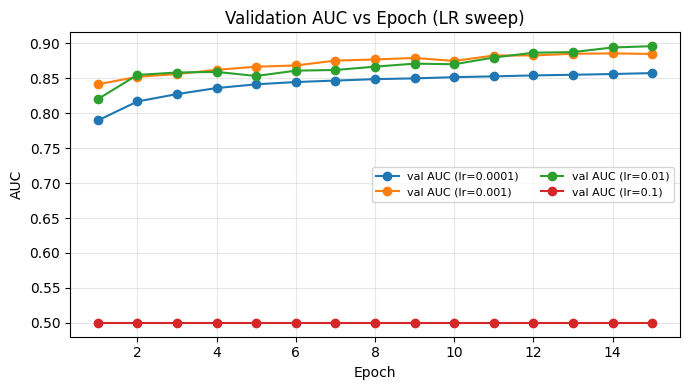

,lr,best_val_auc,last_val_auc,last_val_loss
2,0.010000,0.8959,0.8959,0.4534
1,0.001000,0.8855,0.8848,0.4686
0,0.000100,0.8574,0.8574,0.4611
3,0.100000,0.5000,0.5000,0.6768


In [17]:
# ==== LR sweep (fixed to pass optimizer into runner) ====
def run_one_lr(lr, epochs=2, max_batches_train=100, max_batches_val=100, log_every=50):
    set_seed(42)
    model = SmallCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss":[], "train_auc":[], "val_loss":[], "val_auc":[]}
    best_auc, best_state = -1.0, None

    print(f"\n===== LR SWEEP: lr={lr} =====")
    for ep in range(1, epochs+1):
        print(f"\n-- [lr={lr}] Epoch {ep}/{epochs} --")
        tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
            model, dl_train, train=True,  log_every=log_every, name=f"train(lr={lr})",
            max_batches=max_batches_train, optimizer=optimizer
        )
        va_loss, va_auc, va_time, _ = run_epoch_profiled(
            model, dl_val,   train=False, log_every=log_every, name=f"valid(lr={lr})",
            max_batches=max_batches_val, optimizer=None
        )
        hist["train_loss"].append(tr_loss); hist["train_auc"].append(tr_auc)
        hist["val_loss"].append(va_loss);   hist["val_auc"].append(va_auc)

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
            print(f"[lr={lr}] ** New best AUC {best_auc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    hist["best_val_auc"] = best_auc
    return hist

# Config & run
LR_LIST = [1e-4, 1e-3, 1e-2, 1e-1]
EPOCHS   = 15
MAXB_T   = 200
MAXB_V   = 200

sweep_hist = {lr: run_one_lr(lr, epochs=EPOCHS, max_batches_train=MAXB_T, max_batches_val=MAXB_V, log_every=50)
              for lr in LR_LIST}

# Plots + summary
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(7,4))
for lr in LR_LIST:
    plt.plot(epochs, sweep_hist[lr]["val_loss"], marker="o", label=f"val loss (lr={lr:g})")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss vs Epoch (LR sweep)")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("lr_sweep_val_loss.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
for lr in LR_LIST:
    plt.plot(epochs, sweep_hist[lr]["val_auc"], marker="o", label=f"val AUC (lr={lr:g})")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title("Validation AUC vs Epoch (LR sweep)")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("lr_sweep_val_auc.png", dpi=150); plt.show()

rows = []
for lr in LR_LIST:
    h = sweep_hist[lr]
    rows.append({"lr": lr, "best_val_auc": h["best_val_auc"],
                 "last_val_auc": h["val_auc"][-1], "last_val_loss": h["val_loss"][-1]})
summary_df = pd.DataFrame(rows).sort_values("best_val_auc", ascending=False)
display(summary_df.style.format({"best_val_auc":"{:.4f}","last_val_auc":"{:.4f}","last_val_loss":"{:.4f}"}))

## Weight Decay (L2) Sweep

**Goal.** Evaluate how L2 regularization (PyTorch `weight_decay`) affects stability and generalization using a fixed model (`SmallCNN`) and optimizer (Adam).

**Setup.**
- Sweep: `weight_decay ∈ {0, 1e-6, 1e-4, 1e-2, 1e-1}` at fixed `lr = 1e-3`.
- For each WD, train/validate for a few epochs with capped batches to keep runs short.
- Metrics: loss and AUC per epoch; best val AUC tracked per WD.

**Outputs.**
- Line plots: *Val Loss vs Epoch* and *Val AUC vs Epoch* (one curve per WD).
- Summary table: best/last val AUC and loss for each WD.
- Bar chart: *Best Val AUC by Weight Decay* to visualize the sweet spot.

**What to look for.**
- Too small WD → overfitting (train loss ↓, val AUC stalls/dips).
- Too large WD → underfitting (both losses high, AUC low).
- Choose the WD with the strongest, most stable validation AUC.


===== WD SWEEP: wd=0.0 (lr=0.001) =====

-- [wd=0.0] Epoch 1/15 --
[train(wd=0.0)]  200/200 |  25600 imgs |  1172.2 imgs/s | elapsed   21.8s | loss(last/avg) 0.5690/0.5637
   fetch  68.42 | h2d   1.13 | fwd   0.83 | loss   0.25 | bwd   1.08 | step   0.94 | metrics  25.66  (ms/batch)
[train(wd=0.0)] DONE | avg_loss 0.5637 | AUC 0.7858 | epoch_time 21.8s
PER-BATCH AVERAGES (ms): fetch 68.42 | h2d 1.13 | fwd 0.83 | loss 0.25 | bwd 1.08 | step 0.94 | metrics 25.66
[valid(wd=0.0)]  172/172 |  22003 imgs |  1532.3 imgs/s | elapsed   14.4s | loss(last/avg) 0.5591/0.4850
   fetch  65.68 | h2d   1.13 | fwd   0.72 | loss   0.19 | bwd   0.00 | step   0.00 | metrics   0.49  (ms/batch)
[valid(wd=0.0)] DONE | avg_loss 0.4850 | AUC 0.8412 | epoch_time 14.4s
PER-BATCH AVERAGES (ms): fetch 65.68 | h2d 1.13 | fwd 0.72 | loss 0.19 | bwd 0.00 | step 0.00 | metrics 0.49
[wd=0.0] ** New best AUC 0.8412

-- [wd=0.0] Epoch 2/15 --
[train(wd=0.0)]  200/200 |  25600 imgs |   956.9 imgs/s | elapsed   26.8s | lo

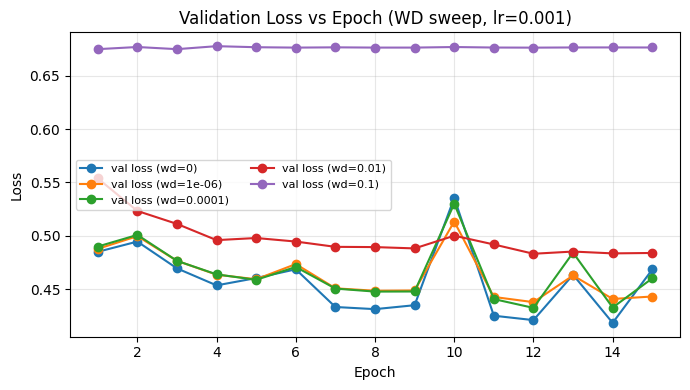

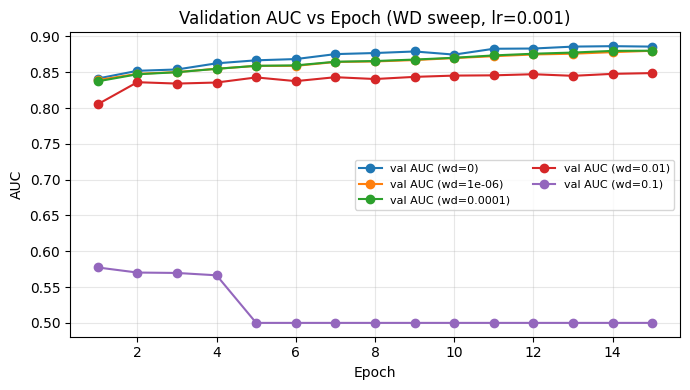

,weight_decay,best_val_auc,last_val_auc,last_val_loss
0,0.000000,0.8864,0.8858,0.4684
2,0.000100,0.8801,0.8801,0.4601
1,0.000001,0.8800,0.8800,0.4431
3,0.010000,0.8488,0.8488,0.4839
4,0.100000,0.5774,0.5000,0.6765


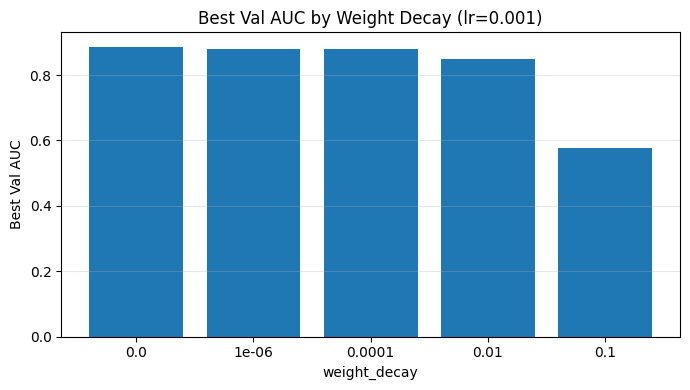

In [18]:
# ==== Weight Decay (L2) sweep using Adam; reuses run_epoch_profiled ====
def run_one_wd(wd, lr=1e-3, epochs=2, max_batches_train=100, max_batches_val=100, log_every=50):
    """Train SmallCNN from scratch at a given weight_decay, return history dict."""
    set_seed(42)
    model = SmallCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)  # ONLY WD changes

    hist = {"train_loss":[], "train_auc":[], "val_loss":[], "val_auc":[]}
    best_auc, best_state = -1.0, None

    print(f"\n===== WD SWEEP: wd={wd} (lr={lr}) =====")
    for ep in range(1, epochs+1):
        print(f"\n-- [wd={wd}] Epoch {ep}/{epochs} --")
        tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
            model, dl_train, train=True,  log_every=log_every, name=f"train(wd={wd})",
            max_batches=max_batches_train, optimizer=optimizer
        )
        va_loss, va_auc, va_time, _ = run_epoch_profiled(
            model, dl_val,   train=False, log_every=log_every, name=f"valid(wd={wd})",
            max_batches=max_batches_val, optimizer=None
        )
        hist["train_loss"].append(tr_loss); hist["train_auc"].append(tr_auc)
        hist["val_loss"].append(va_loss);   hist["val_auc"].append(va_auc)

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
            print(f"[wd={wd}] ** New best AUC {best_auc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    hist["best_val_auc"] = best_auc
    return hist

# ===== Configure sweep =====
LR_FIXED = 1e-3                 # pick your preferred LR (e.g., winner from LR sweep)
WD_LIST  = [0.0, 1e-6, 1e-4, 1e-2, 1e-1]   # try more points if you like
EPOCHS   = 15
MAXB_T   = 200
MAXB_V   = 200
LOG_EVERY = 200

# ===== Run sweep =====
wd_hist = {}
for wd in WD_LIST:
    wd_hist[wd] = run_one_wd(
        wd, lr=LR_FIXED, epochs=EPOCHS,
        max_batches_train=MAXB_T, max_batches_val=MAXB_V,
        log_every=LOG_EVERY
    )

# ===== Plot: multi-line Loss & AUC vs Epoch (one line per WD) =====
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(7,4))
for wd in WD_LIST:
    plt.plot(epochs, wd_hist[wd]["val_loss"], marker="o", label=f"val loss (wd={wd:g})")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Validation Loss vs Epoch (WD sweep, lr={LR_FIXED:g})")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("wd_sweep_val_loss.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
for wd in WD_LIST:
    plt.plot(epochs, wd_hist[wd]["val_auc"], marker="o", label=f"val AUC (wd={wd:g})")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.title(f"Validation AUC vs Epoch (WD sweep, lr={LR_FIXED:g})")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("wd_sweep_val_auc.png", dpi=150); plt.show()

# ===== Summary table & a simple bar chart of best AUC per WD =====
rows = []
for wd in WD_LIST:
    h = wd_hist[wd]
    rows.append({
        "weight_decay": wd,
        "best_val_auc": h["best_val_auc"],
        "last_val_auc": h["val_auc"][-1],
        "last_val_loss": h["val_loss"][-1],
    })
summary_df = pd.DataFrame(rows).sort_values("best_val_auc", ascending=False)
display(summary_df.style.format({"best_val_auc":"{:.4f}","last_val_auc":"{:.4f}","last_val_loss":"{:.4f}"}))

plt.figure(figsize=(7,4))
plt.bar([str(wd) for wd in WD_LIST], [wd_hist[wd]["best_val_auc"] for wd in WD_LIST])
plt.xlabel("weight_decay"); plt.ylabel("Best Val AUC"); plt.title(f"Best Val AUC by Weight Decay (lr={LR_FIXED:g})")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig("wd_sweep_best_val_auc.png", dpi=150); plt.show()

## Optimizer Sweep

**Goal.** Compare common optimizers on the same model/data/config to see which converges fastest and yields the best validation AUC.

**Setup.**
- Fixed config per run: `SmallCNN`, `lr = 1e-3`, `weight_decay = 1e-4`, capped batches for speed.
- Optimizers tested: Adam, AdamW, SGD (m=0.9, Nesterov), RMSprop (m=0.9), Adagrad.
- For each optimizer: train/validate for `EPOCHS`, track loss/AUC and epoch time.

**Outputs.**
- Validation Loss/AUC vs. epoch (one line per optimizer).
- Summary table: best/last val AUC and loss, avg epoch time.
- Bar chart of best validation AUC by optimizer.



===== OPT SWEEP: Adam (lr=0.001, wd=0.0001) =====

-- [Adam] Epoch 1/15 --
[train(Adam)]  200/200 |  25600 imgs |  1159.3 imgs/s | elapsed   22.1s | loss(last/avg) 0.5733/0.5675
   fetch  69.93 | h2d   1.10 | fwd   0.81 | loss   0.25 | bwd   1.05 | step   0.91 | metrics  25.66  (ms/batch)
[train(Adam)] DONE | avg_loss 0.5675 | AUC 0.7821 | epoch_time 22.1s
PER-BATCH AVERAGES (ms): fetch 69.93 | h2d 1.10 | fwd 0.81 | loss 0.25 | bwd 1.05 | step 0.91 | metrics 25.66
[valid(Adam)]  172/172 |  22003 imgs |  1491.5 imgs/s | elapsed   14.8s | loss(last/avg) 0.5630/0.4899
   fetch  68.01 | h2d   1.11 | fwd   0.73 | loss   0.19 | bwd   0.00 | step   0.00 | metrics   0.53  (ms/batch)
[valid(Adam)] DONE | avg_loss 0.4899 | AUC 0.8373 | epoch_time 14.8s
PER-BATCH AVERAGES (ms): fetch 68.01 | h2d 1.11 | fwd 0.73 | loss 0.19 | bwd 0.00 | step 0.00 | metrics 0.53
[Adam] ** New best AUC 0.8373

-- [Adam] Epoch 2/15 --
[train(Adam)]  200/200 |  25600 imgs |  1207.3 imgs/s | elapsed   21.2s | loss(las

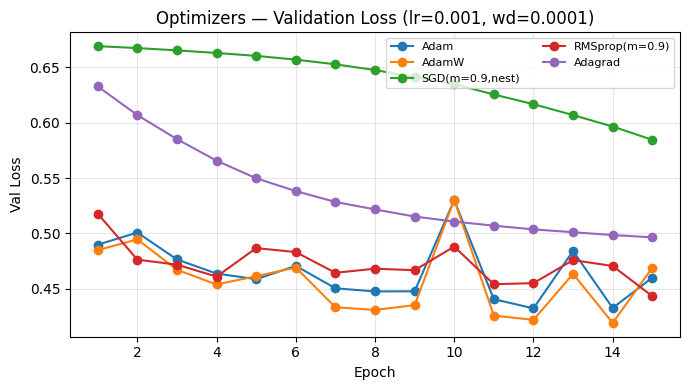

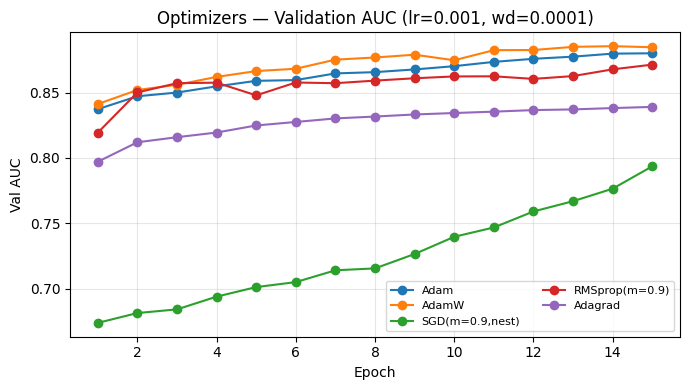

,optimizer,best_val_auc,last_val_auc,last_val_loss,avg_epoch_time_s
1,AdamW,0.8856,0.8847,0.4690,36.9
0,Adam,0.8801,0.8801,0.4601,38.4
3,RMSprop(m=0.9),0.8714,0.8714,0.4435,42.3
4,Adagrad,0.8391,0.8391,0.4965,44.5
2,"SGD(m=0.9,nest)",0.7936,0.7936,0.5845,36.8


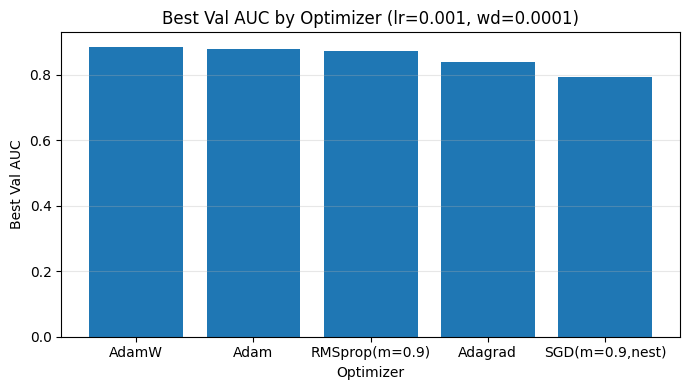

In [19]:
# ==== Optimizer sweep (same config per run) ====

# Registry of optimizers. Each entry is a function that returns an optimizer for a given model.
def make_adam(model, lr, wd):    return torch.optim.Adam(model.parameters(),  lr=lr, weight_decay=wd)
def make_adamw(model, lr, wd):   return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
def make_sgd(model, lr, wd):     return torch.optim.SGD(model.parameters(),   lr=lr, momentum=0.9, nesterov=True, weight_decay=wd)
def make_rmsprop(model, lr, wd): return torch.optim.RMSprop(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
def make_adagrad(model, lr, wd): return torch.optim.Adagrad(model.parameters(),  lr=lr, weight_decay=wd)

OPTIMIZERS = {
    "Adam": make_adam,
    "AdamW": make_adamw,
    "SGD(m=0.9,nest)": make_sgd,
    "RMSprop(m=0.9)": make_rmsprop,
    "Adagrad": make_adagrad,
}

def run_one_optimizer(opt_name, lr=1e-3, weight_decay=0.0, epochs=3,
                      max_batches_train=100, max_batches_val=100, log_every=50):
    """Train SmallCNN from scratch with a given optimizer; return history dict."""
    assert opt_name in OPTIMIZERS, f"Unknown optimizer: {opt_name}"
    set_seed(42)
    model = SmallCNN().to(device)
    optimizer = OPTIMIZERS[opt_name](model, lr, weight_decay)

    hist = {"train_loss":[], "train_auc":[], "val_loss":[], "val_auc":[], "epoch_time": []}
    best_auc, best_state = -1.0, None

    print(f"\n===== OPT SWEEP: {opt_name} (lr={lr}, wd={weight_decay}) =====")
    for ep in range(1, epochs+1):
        print(f"\n-- [{opt_name}] Epoch {ep}/{epochs} --")
        tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
            model, dl_train, train=True,  log_every=log_every, name=f"train({opt_name})",
            max_batches=max_batches_train, optimizer=optimizer
        )
        va_loss, va_auc, va_time, _ = run_epoch_profiled(
            model, dl_val,   train=False, log_every=log_every, name=f"valid({opt_name})",
            max_batches=max_batches_val, optimizer=None
        )
        hist["train_loss"].append(tr_loss); hist["train_auc"].append(tr_auc)
        hist["val_loss"].append(va_loss);   hist["val_auc"].append(va_auc)
        hist["epoch_time"].append(tr_time + va_time)

        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            print(f"[{opt_name}] ** New best AUC {best_auc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    hist["best_val_auc"] = best_auc
    return hist

# ==== Configure & run sweep ====
LR_FIXED = 1e-3          # set to your best LR from the LR sweep
WD_FIXED = 1e-4          # set to your best WD from the WD sweep (or 0.0 to disable)
EPOCHS   = 15
MAXB_T   = 200
MAXB_V   = 200
LOG_EVERY = 200

opt_hist = {}
for name in OPTIMIZERS.keys():
    opt_hist[name] = run_one_optimizer(
        name, lr=LR_FIXED, weight_decay=WD_FIXED, epochs=EPOCHS,
        max_batches_train=MAXB_T, max_batches_val=MAXB_V, log_every=LOG_EVERY
    )

# ==== Plot: Val Loss & Val AUC vs Epoch (one line per optimizer) ====
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(7,4))
for name in OPTIMIZERS.keys():
    plt.plot(epochs, opt_hist[name]["val_loss"], marker="o", label=name)
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title(f"Optimizers — Validation Loss (lr={LR_FIXED:g}, wd={WD_FIXED:g})")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("opt_sweep_val_loss.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
for name in OPTIMIZERS.keys():
    plt.plot(epochs, opt_hist[name]["val_auc"], marker="o", label=name)
plt.xlabel("Epoch"); plt.ylabel("Val AUC"); plt.title(f"Optimizers — Validation AUC (lr={LR_FIXED:g}, wd={WD_FIXED:g})")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("opt_sweep_val_auc.png", dpi=150); plt.show()

# ==== Summary table & bar chart of best AUC ====
rows = []
for name in OPTIMIZERS.keys():
    h = opt_hist[name]
    rows.append({
        "optimizer": name,
        "best_val_auc": h["best_val_auc"],
        "last_val_auc": h["val_auc"][-1],
        "last_val_loss": h["val_loss"][-1],
        "avg_epoch_time_s": np.mean(h["epoch_time"]),
    })
summary_df = pd.DataFrame(rows).sort_values("best_val_auc", ascending=False)
display(summary_df.style.format({
    "best_val_auc": "{:.4f}",
    "last_val_auc": "{:.4f}",
    "last_val_loss": "{:.4f}",
    "avg_epoch_time_s": "{:.1f}",
}))

plt.figure(figsize=(7,4))
plt.bar(summary_df["optimizer"], summary_df["best_val_auc"])
plt.xlabel("Optimizer"); plt.ylabel("Best Val AUC"); plt.title(f"Best Val AUC by Optimizer (lr={LR_FIXED:g}, wd={WD_FIXED:g})")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.savefig("opt_sweep_best_val_auc.png", dpi=150); plt.show()

## Depth Sweep: 1, 3, 5, 7 Conv Blocks

**What this does.** Builds a configurable CNN (`DepthCNN`) and compares depths {1, 3, 5, 7} under identical training settings.

**How it’s built.**
- Each block: `Conv3×3 → BN → ReLU`; `MaxPool2d(2)` after every other block to limit downsampling.
- Channels grow linearly: `c[i] = base + i·grow` (defaults: base=32, grow=16).
- Optional late-layer `Dropout2d`.

**Training setup.**
- Optimizer: Adam (`lr=1e-3`, `weight_decay=1e-4`), `EPOCHS=5`.
- Capped batches for speed (`train=100`, `val=100` per epoch).
- Records train/val loss, val AUC, and epoch time; restores best AUC checkpoint.

**Outputs.**
- Line plots: Val AUC vs epoch and Val Loss vs epoch (one line per depth).
- Summary table: depth, params (M), best/last val AUC, last val loss, avg epoch time (s).
- Bar charts: Best AUC by depth, Params by depth, and Avg epoch time by depth.

**How to read it.**
- Look for the shallowest depth that reaches near-top AUC.
- If deeper wins only marginally, prefer smaller depth for speed/size.
- If deeper overfits (loss↓, AUC plateaus/falls), consider more pooling, dropout, or weight decay.


===== DEPTH SWEEP: depth=1 (params=961) =====

-- [depth=1] Epoch 1/15 --
[train(d=1)]  200/200 |  25600 imgs |   775.7 imgs/s | elapsed   33.0s | loss(last/avg) 0.5929/0.6120
   fetch 117.96 | h2d   1.62 | fwd   2.34 | loss   0.35 | bwd   1.96 | step   1.90 | metrics  25.36  (ms/batch)
[train(d=1)] DONE | avg_loss 0.6120 | AUC 0.7136 | epoch_time 33.0s
PER-BATCH AVERAGES (ms): fetch 117.96 | h2d 1.62 | fwd 2.34 | loss 0.35 | bwd 1.96 | step 1.90 | metrics 25.36
[valid(d=1)]  172/172 |  22003 imgs |   499.8 imgs/s | elapsed   44.0s | loss(last/avg) 0.5779/0.5564
   fetch 225.58 | h2d   3.56 | fwd   3.63 | loss   0.60 | bwd   0.00 | step   0.00 | metrics   4.11  (ms/batch)
[valid(d=1)] DONE | avg_loss 0.5564 | AUC 0.7935 | epoch_time 44.1s
PER-BATCH AVERAGES (ms): fetch 225.58 | h2d 3.56 | fwd 3.63 | loss 0.60 | bwd 0.00 | step 0.00 | metrics 4.11
[depth=1] ** New best AUC 0.7935

-- [depth=1] Epoch 2/15 --
[train(d=1)]  200/200 |  25600 imgs |   600.8 imgs/s | elapsed   42.6s | loss(l

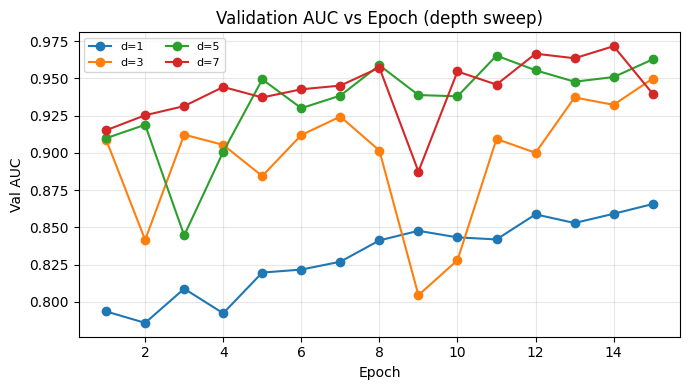

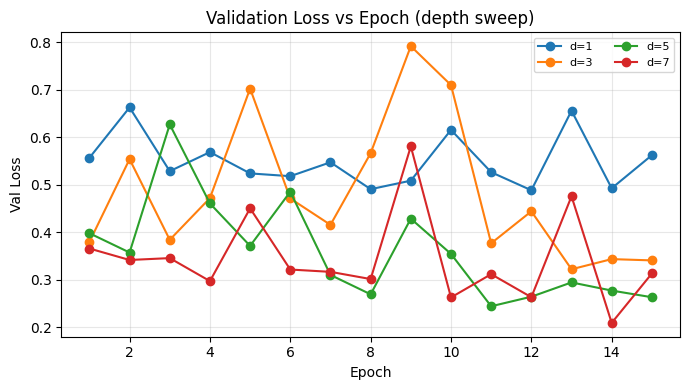

,depth,params_M,best_val_auc,last_val_auc,last_val_loss,avg_epoch_time_s
3,7,0.38,0.9716,0.9397,0.3131,128.2
2,5,0.16,0.9653,0.9628,0.2631,78.5
1,3,0.04,0.9499,0.9499,0.3406,55.4
0,1,0.00,0.8656,0.8656,0.5620,42.3


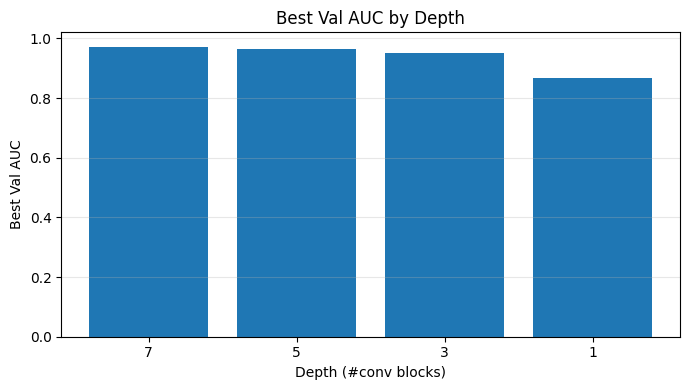

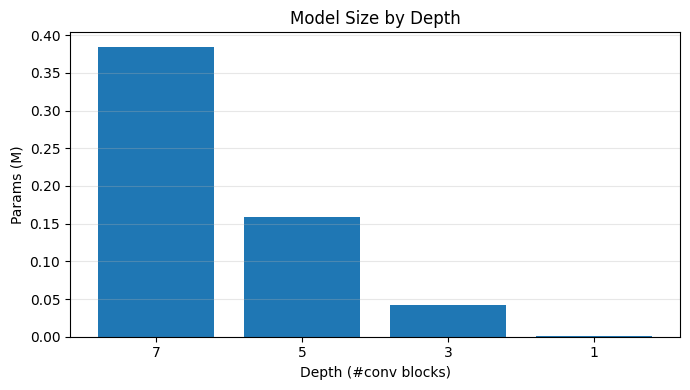

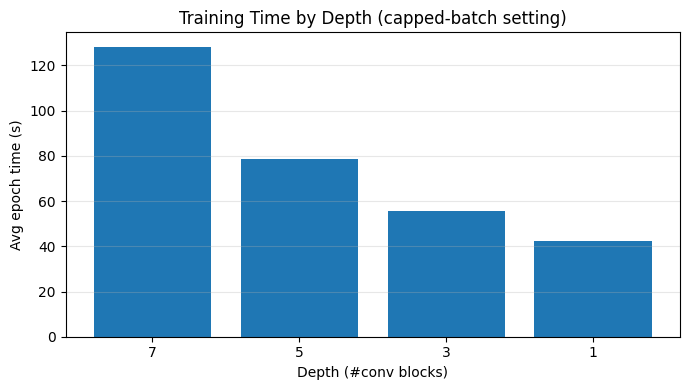

In [20]:
# ==== Depth (conv-layer) sweep: 1, 3, 5, 7 blocks ====

# -- utilities
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# -- model factory: build a D-layer CNN with pooling every other block
class DepthCNN(nn.Module):
    """
    D blocks of: Conv3x3 -> BN -> ReLU, with optional MaxPool2d(2) every other block.
    Channels grow linearly with depth: c[i] = base + i*grow.
    """
    def __init__(self, depth=3, base=32, grow=16, use_dropout=False, p_drop=0.2):
        super().__init__()
        assert depth >= 1
        channels = [3] + [base + i*grow for i in range(depth)]  # e.g. 3 -> 32 -> 48 -> 64 ...
        blocks = []
        for i in range(depth):
            cin, cout = channels[i], channels[i+1]
            blocks += [
                nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
            ]
            # pool every other block (i = 1,3,5,...) to avoid over-downsampling
            if i % 2 == 1:
                blocks.append(nn.MaxPool2d(2))
            if use_dropout and i >= max(1, depth//2):  # mild dropout in later layers
                blocks.append(nn.Dropout2d(p_drop))
        self.features = nn.Sequential(*blocks, nn.AdaptiveAvgPool2d(1))
        self.head = nn.Linear(channels[-1], 1)

    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.head(x).squeeze(1)

# -- single run for a given depth
def run_one_depth(depth, lr=1e-3, weight_decay=1e-4, epochs=3,
                  max_batches_train=100, max_batches_val=100, log_every=50,
                  base=32, grow=16, use_dropout=False):
    set_seed(42)
    model = DepthCNN(depth=depth, base=base, grow=grow, use_dropout=use_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss":[], "train_auc":[], "val_loss":[], "val_auc":[], "epoch_time": []}
    best_auc, best_state = -1.0, None

    print(f"\n===== DEPTH SWEEP: depth={depth} (params={count_params(model):,}) =====")
    for ep in range(1, epochs+1):
        print(f"\n-- [depth={depth}] Epoch {ep}/{epochs} --")
        tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
            model, dl_train, train=True,  log_every=log_every, name=f"train(d={depth})",
            max_batches=max_batches_train, optimizer=optimizer
        )
        va_loss, va_auc, va_time, _ = run_epoch_profiled(
            model, dl_val,   train=False, log_every=log_every, name=f"valid(d={depth})",
            max_batches=max_batches_val, optimizer=None
        )
        hist["train_loss"].append(tr_loss); hist["train_auc"].append(tr_auc)
        hist["val_loss"].append(va_loss);   hist["val_auc"].append(va_auc)
        hist["epoch_time"].append(tr_time + va_time)
        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            print(f"[depth={depth}] ** New best AUC {best_auc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    hist["best_val_auc"] = best_auc
    hist["params"] = count_params(model)
    return hist

# ---- sweep config ----
DEPTH_LIST = [1, 3, 5, 7]   # your “skew”
EPOCHS     = 15              # keep small with capped batches for speed
LR_FIXED   = 1e-3
WD_FIXED   = 1e-4
MAXB_T   = 200
MAXB_V   = 200
LOG_EVERY = 200

# channel schedule (tune if you want wider/narrower nets)
BASE_CH    = 32
GROW_CH    = 16
USE_DROPOUT= False

# ---- run sweep ----
depth_hist = {}
for d in DEPTH_LIST:
    depth_hist[d] = run_one_depth(
        depth=d, lr=LR_FIXED, weight_decay=WD_FIXED, epochs=EPOCHS,
        max_batches_train=MAXB_T, max_batches_val=MAXB_V, log_every=LOG_EVERY,
        base=BASE_CH, grow=GROW_CH, use_dropout=USE_DROPOUT
    )

# ---- plots: AUC & Loss vs epoch for each depth ----
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(7,4))
for d in DEPTH_LIST:
    plt.plot(epochs, depth_hist[d]["val_auc"], marker="o", label=f"d={d}")
plt.xlabel("Epoch"); plt.ylabel("Val AUC"); plt.title("Validation AUC vs Epoch (depth sweep)")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("depth_sweep_val_auc.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
for d in DEPTH_LIST:
    plt.plot(epochs, depth_hist[d]["val_loss"], marker="o", label=f"d={d}")
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Validation Loss vs Epoch (depth sweep)")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("depth_sweep_val_loss.png", dpi=150); plt.show()

# ---- summary table + bars (best AUC, params, time) ----
rows = []
for d in DEPTH_LIST:
    h = depth_hist[d]
    rows.append({
        "depth": d,
        "params_M": h["params"] / 1e6,
        "best_val_auc": h["best_val_auc"],
        "last_val_auc": h["val_auc"][-1],
        "last_val_loss": h["val_loss"][-1],
        "avg_epoch_time_s": float(np.mean(h["epoch_time"])),
    })
summary_df = pd.DataFrame(rows).sort_values(["best_val_auc","depth"], ascending=[False, True])
display(summary_df.style.format({
    "params_M": "{:.2f}",
    "best_val_auc": "{:.4f}",
    "last_val_auc": "{:.4f}",
    "last_val_loss": "{:.4f}",
    "avg_epoch_time_s": "{:.1f}",
}))

plt.figure(figsize=(7,4))
plt.bar(summary_df["depth"].astype(str), summary_df["best_val_auc"])
plt.xlabel("Depth (#conv blocks)"); plt.ylabel("Best Val AUC"); plt.title("Best Val AUC by Depth")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig("depth_sweep_best_val_auc.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
plt.bar(summary_df["depth"].astype(str), summary_df["params_M"])
plt.xlabel("Depth (#conv blocks)"); plt.ylabel("Params (M)"); plt.title("Model Size by Depth")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig("depth_sweep_params.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
plt.bar(summary_df["depth"].astype(str), summary_df["avg_epoch_time_s"])
plt.xlabel("Depth (#conv blocks)"); plt.ylabel("Avg epoch time (s)")
plt.title("Training Time by Depth (capped-batch setting)")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig("depth_sweep_time.png", dpi=150); plt.show()

## Architecture Sweep (from-scratch CNNs)

**What this does.** Trains several small CNN variants under the same settings and compares validation performance, size, and speed.

**Models.**
- `SmallCNN` — baseline (2 conv blocks + GAP + FC).
- `WiderCNN` — same depth, more channels.
- `DeeperBN` — adds a third conv block and BatchNorm.
- `TinyResNet` — residual blocks with identity skips.
- `TinyMobile` — depthwise-separable (MobileNet-style) convolutions.

**How it runs.**
- Uses the profiled epoch runner with fixed `lr=1e-3`, `weight_decay=1e-4`, `EPOCHS=10`, and capped batches for speed.
- For each architecture: records train/val loss, val AUC, per-epoch time; tracks best val AUC; restores best weights.

**Outputs.**
- Line plots: Validation Loss and Validation AUC vs. epoch (one line per architecture).
- Summary table: parameters (M), best/last val AUC, last val loss, average epoch time (s).
- Bar charts: Best Val AUC by architecture; Model size (params in millions).

**Reading the results.**
- Prefer models with higher and steadier val AUC and reasonable parameter count.
- If two models tie on AUC, consider epoch time and parameter budget.
- Depthwise-separable (`TinyMobile`) often offers strong AUC/compute trade-offs; residuals can stabilize deeper stacks.


===== ARCH SWEEP: SmallCNN (params=19,457) =====

-- [SmallCNN] Epoch 1/15 --
[train(SmallCNN)]  200/200 |  25600 imgs |   931.5 imgs/s | elapsed   27.5s | loss(last/avg) 0.5730/0.5675
   fetch  88.02 | h2d   1.55 | fwd   1.20 | loss   0.30 | bwd   2.01 | step   1.39 | metrics  28.33  (ms/batch)
[train(SmallCNN)] DONE | avg_loss 0.5675 | AUC 0.7821 | epoch_time 27.5s
PER-BATCH AVERAGES (ms): fetch 88.02 | h2d 1.55 | fwd 1.20 | loss 0.30 | bwd 2.01 | step 1.39 | metrics 28.33
[valid(SmallCNN)]  172/172 |  22003 imgs |  1464.2 imgs/s | elapsed   15.0s | loss(last/avg) 0.5628/0.4898
   fetch  68.88 | h2d   1.26 | fwd   0.77 | loss   0.20 | bwd   0.00 | step   0.00 | metrics   0.53  (ms/batch)
[valid(SmallCNN)] DONE | avg_loss 0.4898 | AUC 0.8374 | epoch_time 15.0s
PER-BATCH AVERAGES (ms): fetch 68.88 | h2d 1.26 | fwd 0.77 | loss 0.20 | bwd 0.00 | step 0.00 | metrics 0.53
[SmallCNN] ** New best AUC 0.8374

-- [SmallCNN] Epoch 2/15 --
[train(SmallCNN)]  200/200 |  25600 imgs |  1158.8 imgs

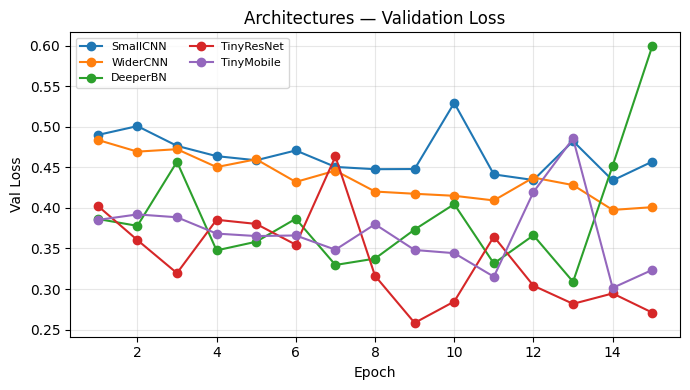

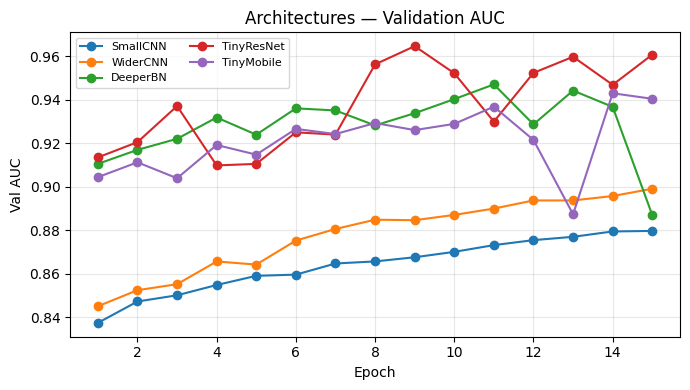

,architecture,params_M,best_val_auc,last_val_auc,last_val_loss,avg_epoch_time_s
3,TinyResNet,0.11,0.9647,0.9608,0.2710,79.2
2,DeeperBN,0.09,0.9471,0.8870,0.5992,46.4
4,TinyMobile,0.01,0.9430,0.9405,0.3236,39.4
1,WiderCNN,0.08,0.8991,0.8991,0.4009,56.6
0,SmallCNN,0.02,0.8797,0.8797,0.4570,36.6


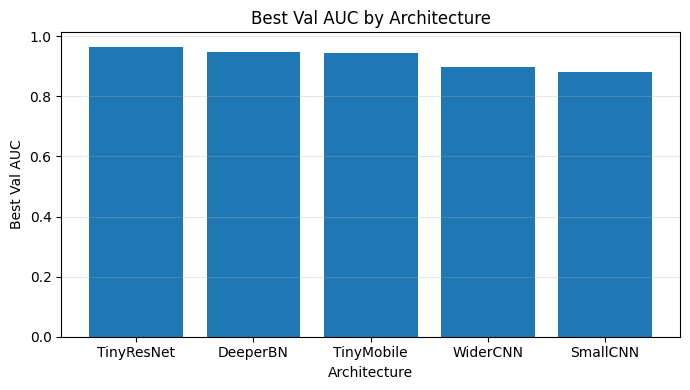

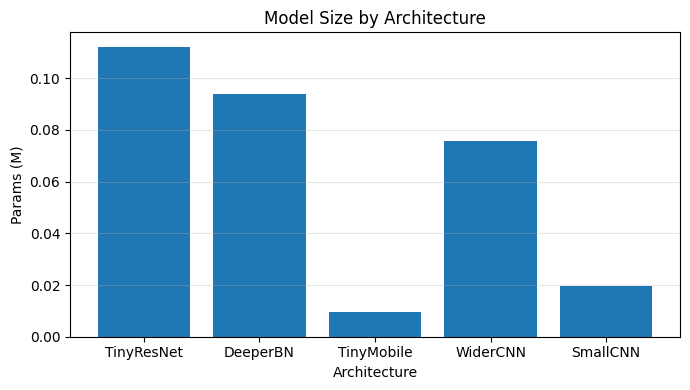

In [21]:
# ==== CNN Architecture Sweep (no transfer learning) ====
# ------------- Utilities -------------
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# ------------- Model Zoo (all from scratch) -------------
# Your current baseline
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # S/2
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # S/4
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64, 1))
    def forward(self, x): return self.head(self.features(x)).squeeze(1)

# (A) Wider: more channels, same depth
class WiderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(128, 1))
    def forward(self, x): return self.head(self.features(x)).squeeze(1)

# (B) Deeper: add a third block + BatchNorm
class DeeperBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(128, 1))
    def forward(self, x): return self.head(self.features(x)).squeeze(1)

# (C) Residual: lightweight ResNet-ish with identity skip
class BasicBlock(nn.Module):
    def __init__(self, c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(c, c, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(c)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(c)
        self.down  = nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class TinyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.layer1 = nn.Sequential(BasicBlock(32), nn.MaxPool2d(2))   # S/2
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            BasicBlock(64),
            nn.MaxPool2d(2)                                            # S/4
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(64, 1)
    def forward(self, x):
        x = self.stem(x); x = self.layer1(x); x = self.layer2(x)
        x = self.pool(x).flatten(1)
        return self.head(x).squeeze(1)

# (D) Depthwise-separable: MobileNet-style convs (very light)
class DWConv(nn.Module):
    def __init__(self, cin, cout, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(cin, cin, 3, stride=stride, padding=1, groups=cin, bias=False)
        self.pw = nn.Conv2d(cin, cout, 1, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.pw(self.dw(x))))

class TinyMobile(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            DWConv(3, 32, stride=1),  nn.MaxPool2d(2),      # S/2
            DWConv(32, 64, stride=1), nn.MaxPool2d(2),      # S/4
            DWConv(64, 96, stride=1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(96, 1))
    def forward(self, x): return self.head(self.features(x)).squeeze(1)

ARCHS = {
    "SmallCNN":   SmallCNN,
    "WiderCNN":   WiderCNN,
    "DeeperBN":   DeeperBN,
    "TinyResNet": TinyResNet,
    "TinyMobile": TinyMobile,
}

# ------------- Sweep runner -------------
def run_one_arch(arch_name, lr=1e-3, weight_decay=1e-4, epochs=3,
                 max_batches_train=100, max_batches_val=100, log_every=50):
    set_seed(42)
    model = ARCHS[arch_name]().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss":[], "train_auc":[], "val_loss":[], "val_auc":[], "epoch_time": []}
    best_auc, best_state = -1.0, None

    print(f"\n===== ARCH SWEEP: {arch_name} (params={count_params(model):,}) =====")
    for ep in range(1, epochs+1):
        print(f"\n-- [{arch_name}] Epoch {ep}/{epochs} --")
        tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
            model, dl_train, train=True,  log_every=log_every, name=f"train({arch_name})",
            max_batches=max_batches_train, optimizer=optimizer
        )
        va_loss, va_auc, va_time, _ = run_epoch_profiled(
            model, dl_val,   train=False, log_every=log_every, name=f"valid({arch_name})",
            max_batches=max_batches_val, optimizer=None
        )
        hist["train_loss"].append(tr_loss); hist["train_auc"].append(tr_auc)
        hist["val_loss"].append(va_loss);   hist["val_auc"].append(va_auc)
        hist["epoch_time"].append(tr_time + va_time)
        if va_auc > best_auc:
            best_auc = va_auc
            best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
            print(f"[{arch_name}] ** New best AUC {best_auc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    hist["best_val_auc"] = best_auc
    hist["params"] = count_params(model)
    return hist

# ------------- Configure & run -------------
LR_FIXED = 1e-3            # use your best LR
WD_FIXED = 1e-4            # use your best WD (or 0.0)
EPOCHS   = 15
MAXB_T   = 200
MAXB_V   = 200
LOG_EVERY = 200

arch_hist = {}
for name in ARCHS.keys():
    arch_hist[name] = run_one_arch(
        name, lr=LR_FIXED, weight_decay=WD_FIXED, epochs=EPOCHS,
        max_batches_train=MAXB_T, max_batches_val=MAXB_V, log_every=LOG_EVERY
    )

# ------------- Plots: Val Loss & Val AUC vs Epoch -------------
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(7,4))
for name in ARCHS.keys():
    plt.plot(epochs, arch_hist[name]["val_loss"], marker="o", label=f"{name}")
plt.xlabel("Epoch"); plt.ylabel("Val Loss"); plt.title("Architectures — Validation Loss")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("arch_sweep_val_loss.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
for name in ARCHS.keys():
    plt.plot(epochs, arch_hist[name]["val_auc"], marker="o", label=f"{name}")
plt.xlabel("Epoch"); plt.ylabel("Val AUC"); plt.title("Architectures — Validation AUC")
plt.grid(True, alpha=0.3); plt.legend(ncols=2, fontsize=8)
plt.tight_layout(); plt.savefig("arch_sweep_val_auc.png", dpi=150); plt.show()

# ------------- Summary table + bars -------------
rows = []
for name in ARCHS.keys():
    h = arch_hist[name]
    rows.append({
        "architecture": name,
        "params_M": h["params"] / 1e6,
        "best_val_auc": h["best_val_auc"],
        "last_val_auc": h["val_auc"][-1],
        "last_val_loss": h["val_loss"][-1],
        "avg_epoch_time_s": float(np.mean(h["epoch_time"]))
    })
summary_df = pd.DataFrame(rows).sort_values("best_val_auc", ascending=False)
display(summary_df.style.format({
    "params_M": "{:.2f}",
    "best_val_auc": "{:.4f}",
    "last_val_auc": "{:.4f}",
    "last_val_loss": "{:.4f}",
    "avg_epoch_time_s": "{:.1f}",
}))

plt.figure(figsize=(7,4))
plt.bar(summary_df["architecture"], summary_df["best_val_auc"])
plt.xlabel("Architecture"); plt.ylabel("Best Val AUC"); plt.title("Best Val AUC by Architecture")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig("arch_sweep_best_val_auc.png", dpi=150); plt.show()

plt.figure(figsize=(7,4))
plt.bar(summary_df["architecture"], summary_df["params_M"])
plt.xlabel("Architecture"); plt.ylabel("Params (M)"); plt.title("Model Size by Architecture")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig("arch_sweep_params.png", dpi=150); plt.show()

# Results & Analysis

## Baseline (SmallCNN)
- Trained for 15 epochs with Adam (lr=1e-3, wd=1e-4).
- **Val AUC peaked at ~0.888** (Epoch 14: 0.8882), with gradual loss reduction and steady throughput.
- This gives us a solid, reproducible starting point but leaves clear headroom.

---

## Hyperparameter Tuning

### Learning Rate (Adam)
| lr      | best_val_auc | last_val_auc | last_val_loss |
|---------|---------------|--------------|---------------|
| 1e-2    | **0.8959**    | 0.8959       | 0.4534        |
| 1e-3    | 0.8855        | 0.8848       | 0.4686        |
| 1e-4    | 0.8574        | 0.8574       | 0.4611        |
| 1e-1    | 0.5000        | 0.5000       | 0.6768        |

**Takeaway:** Moderately aggressive LR (**1e-2**) helped optimization and yielded the best AUC. Too large (1e-1) collapsed training; too small (1e-4) underfit.

---

### Weight Decay (Adam, lr=1e-3)
| weight_decay | best_val_auc | last_val_auc | last_val_loss |
|--------------|---------------|--------------|---------------|
| **0.0**      | **0.8864**    | 0.8858       | 0.4684        |
| 1e-4         | 0.8801        | 0.8801       | 0.4601        |
| 1e-6         | 0.8800        | 0.8800       | 0.4431        |
| 1e-2         | 0.8488        | 0.8488       | 0.4839        |
| 1e-1         | 0.5774        | 0.5000       | 0.6765        |

**Takeaway:** On this setup, **no L2** was slightly better. Small WD values were close; large WD hurt a lot (underfitting/optimization drag).

---

### Optimizers (lr=1e-3, wd=1e-4)
| optimizer         | best_val_auc | last_val_auc | last_val_loss | avg_epoch_time_s |
|-------------------|--------------|--------------|----------------|------------------|
| **AdamW**         | **0.8856**   | 0.8847       | 0.4690         | 36.9             |
| Adam              | 0.8801       | 0.8801       | 0.4601         | 38.4             |
| RMSprop (m=0.9)   | 0.8714       | 0.8714       | 0.4435         | 42.3             |
| Adagrad           | 0.8391       | 0.8391       | 0.4965         | 44.5             |
| SGD (m=0.9, nest) | 0.7936       | 0.7936       | 0.5845         | 36.8             |

**Takeaway:** **AdamW ≈ Adam** and both clearly ahead of RMSprop/Adagrad/SGD in this regime. Optimizer choice mattered, but not as much as architecture/depth.

---

## Architecture & Capacity

### Depth Sweep (DepthCNN)
| depth (blocks) | params_M | best_val_auc | last_val_auc | last_val_loss | avg_epoch_time_s |
|----------------|----------|--------------|--------------|---------------|------------------|
| **7**          | 0.38     | **0.9716**   | 0.9397       | 0.3131        | 128.2            |
| 5              | 0.16     | 0.9653       | 0.9628       | 0.2631        | 78.5             |
| 3              | 0.04     | 0.9499       | 0.9499       | 0.3406        | 55.4             |
| 1              | 0.00     | 0.8656       | 0.8656       | 0.5620        | 42.3             |

**Takeaway:** **Depth was the single biggest lever.** AUC climbed steadily with depth; compute cost also increased but remained manageable. The 7-block model delivered a **step-change** in validation AUC.

---

### Architecture Sweep
| architecture | params_M | best_val_auc | last_val_auc | last_val_loss | avg_epoch_time_s |
|--------------|----------|--------------|--------------|---------------|------------------|
| **TinyResNet** | 0.11   | **0.9647**   | 0.9608       | 0.2710        | 79.2             |
| DeeperBN     | 0.09     | 0.9471       | 0.8870       | 0.5992        | 46.4             |
| TinyMobile   | 0.01     | 0.9430       | 0.9405       | 0.3236        | 39.4             |
| WiderCNN     | 0.08     | 0.8991       | 0.8991       | 0.4009        | 56.6             |
| SmallCNN     | 0.02     | 0.8797       | 0.8797       | 0.4570        | 36.6             |

**Takeaway:** **Skip connections win.** The lightweight **TinyResNet** outperformed all other small models at modest parameter cost. Depthwise-separable (TinyMobile) was strong given its tiny size, but still trailed residuals.

---

## What Mattered Most (in order)

1. **Model capacity/topology**: Moving from SmallCNN to **TinyResNet** or a deeper stack drove the largest AUC gains (≈+0.07 to +0.09 absolute).
2. **Depth**: More conv blocks improved representation and effective receptive field; 7-blocks achieved **~0.972** best AUC.
3. **Learning rate**: Proper LR (**1e-2** with Adam) improved convergence and final AUC vs 1e-3/1e-4.
4. **Weight decay**: Small/no WD was better here; heavy WD hindered optimization.
5. **Optimizer**: **AdamW/Adam** worked best; others lagged in this setup.

---

## Next Steps

**Future Improvements**
- Stronger data augmentation (color jitter, flips/rotations, RandAugment), CutMix/MixUp, and label smoothing.
- LR schedule (cosine decay with warmup), early stopping, k-fold ensembling.
- Slightly higher input resolution and/or Squeeze-and-Excitation blocks.

# Best Model Submittion to Kaggle

In [26]:
# Train a 7-layer DepthCNN (minimal, uses your existing dl_train/dl_val + run_epoch_profiled)

import torch, torch.nn as nn
from pathlib import Path
import numpy as np, random

# -- seed/device
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)
device = next(model.parameters()).device if 'model' in globals() else (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if hasattr(torch.backends,"mps") and torch.backends.mps.is_available()
    else torch.device("cpu")
)

# -- model
class DepthCNN(nn.Module):
    def __init__(self, depth=7, base=32, grow=16, use_dropout=False, p_drop=0.2):
        super().__init__()
        ch = [3] + [base + i*grow for i in range(depth)]
        blocks = []
        for i in range(depth):
            cin, cout = ch[i], ch[i+1]
            blocks += [nn.Conv2d(cin, cout, 3, padding=1, bias=False),
                       nn.BatchNorm2d(cout), nn.ReLU(inplace=True)]
            if i % 2 == 1: blocks.append(nn.MaxPool2d(2))
            if use_dropout and i >= max(1, depth//2): blocks.append(nn.Dropout2d(p_drop))
        self.features = nn.Sequential(*blocks, nn.AdaptiveAvgPool2d(1))
        self.head = nn.Linear(ch[-1], 1)
    def forward(self, x): return self.head(self.features(x).flatten(1)).squeeze(1)

model = DepthCNN(depth=7, base=32, grow=16).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# -- train
EPOCHS, MAXB_T, MAXB_V, LOG_EVERY = 10, 200, 200, 100
best_auc, best_state = -1.0, None
ckpt = Path("checkpoints"); ckpt.mkdir(exist_ok=True, parents=True)

print("\n=== Train DepthCNN (d=7) ===")
for ep in range(1, EPOCHS+1):
    tr_loss, tr_auc, tr_time, _ = run_epoch_profiled(
        model, dl_train, train=True,  log_every=LOG_EVERY, name="train(d=7)",
        max_batches=MAXB_T, optimizer=optimizer, criterion=criterion
    )
    va_loss, va_auc, va_time, _ = run_epoch_profiled(
        model, dl_val,   train=False, log_every=LOG_EVERY, name="valid(d=7)",
        max_batches=MAXB_V, optimizer=None, criterion=criterion
    )
    if va_auc > best_auc:
        best_auc = va_auc
        best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
        torch.save(best_state, ckpt/"DepthCNN_d7_best.pth")
        print(f"** new best AUC {best_auc:.4f} (saved)")

# -- load best back to model
if best_state is not None:
    model.load_state_dict(best_state)
print(f"\nBest val AUC (d=7): {best_auc:.4f} | weights: {ckpt/'DepthCNN_d7_best.pth'}")


=== Train DepthCNN (d=7) ===
[train(d=7)]  100/200 |  12800 imgs |   212.6 imgs/s | elapsed   60.2s | loss(last/avg) 0.3343/0.4222
   fetch 300.00 | h2d   3.67 | fwd  21.12 | loss   3.14 | bwd  27.24 | step  29.24 | metrics 123.89  (ms/batch)
[train(d=7)]  200/200 |  25600 imgs |   257.4 imgs/s | elapsed   99.5s | loss(last/avg) 0.4214/0.4025
   fetch 229.82 | h2d   3.14 | fwd  16.22 | loss   1.91 | bwd  20.61 | step  20.65 | metrics 127.87  (ms/batch)
[train(d=7)] DONE | avg_loss 0.4025 | AUC 0.8945 | epoch_time 99.5s
PER-BATCH AVERAGES (ms): fetch 229.82 | h2d 3.14 | fwd 16.22 | loss 1.91 | bwd 20.61 | step 20.65 | metrics 127.87
[valid(d=7)]  100/172 |  12800 imgs |   596.6 imgs/s | elapsed   21.5s | loss(last/avg) 0.3326/0.3655
   fetch 148.84 | h2d   2.79 | fwd   7.46 | loss   0.62 | bwd   0.00 | step   0.00 | metrics   2.61  (ms/batch)
[valid(d=7)]  172/172 |  22003 imgs |   659.6 imgs/s | elapsed   33.4s | loss(last/avg) 0.4963/0.3656
   fetch 131.14 | h2d   2.34 | fwd   6.48 |